In [1]:
import cv2
import os
import matplotlib.pyplot as plt
from python_orb_slam3 import ORBExtractor
import numpy as np
from scipy.spatial import cKDTree
import random
import pandas as pd
import quaternion
import copy

In [2]:
def estimate_camera_motion(keypoints1, keypoints2, descriptors1, descriptors2, K):

    # Создаем дерево кД для быстрого поиска ближайших соседей
    tree = cKDTree(descriptors2)
    distances, indices = tree.query(descriptors1, k=2)

    # Применяем тест Лоу для фильтрации соответствий
    good_matches = []
    for idx, (dist1, dist2) in enumerate(zip(distances[:, 0], distances[:, 1])):
        if dist1 < 0.8 * dist2:
            good_matches.append((keypoints1[idx], keypoints2[indices[idx][0]]))

    # Преобразуем соответствия в массивы координат
    src_pts = np.float32([kp1.pt for kp1, _ in good_matches])
    dst_pts = np.float32([kp2.pt for _, kp2 in good_matches])

    # Преобразуем точки в нормализованное пространство камеры
    src_pts_norm = cv2.undistortPoints(src_pts.reshape(-1, 1, 2), K, None, P=K).reshape(-1, 2)
    dst_pts_norm = cv2.undistortPoints(dst_pts.reshape(-1, 1, 2), K, None, P=K).reshape(-1, 2)

    # Вычисляем эссенциальную матрицу
    E, _ = cv2.findEssentialMat(src_pts_norm, dst_pts_norm, K, method=cv2.LMEDS, prob=0.99, threshold=1.0)

    # Декомпозируем эссенциальную матрицу для получения R и t
    points, R, t, mask = cv2.recoverPose(E, src_pts_norm, dst_pts_norm, K)

    return R, t

In [3]:
f = os.listdir('images_from_cam')
f_ext = [[float(x[:-4]), x] for x in f]
f_ext.sort()
f = [x[1] for x in f_ext]

old_frame = cv2.imread('images_from_cam/0.05.jpg')
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
orb_extractor = ORBExtractor()
old_kp, old_desc = orb_extractor.detectAndCompute(old_gray)

focal_length = old_gray.shape[1]
K = np.array([[focal_length, 0, focal_length/2],
              [0, focal_length, focal_length/2],
              [0, 0, 1]])

Rs = []
Ts = []

for filename in f[2:]:
    
    frame = cv2.imread(os.path.join('images_from_cam',filename))
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    new_kp, new_desc = orb_extractor.detectAndCompute(frame_gray)

    R,T = estimate_camera_motion(old_kp, new_kp, old_desc, new_desc, K)

    old_kp, old_desc = new_kp, new_desc
    
    Rs.append(R)
    Ts.append(T)

In [4]:
def moving_average_cumsum(data, window_size):
    
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size   

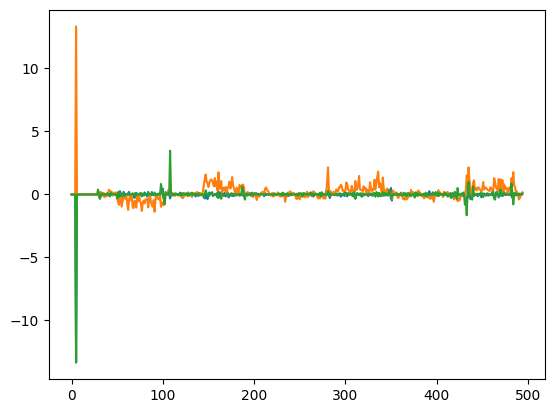

In [5]:
offset = 4

plt.plot(range(len(Rs[offset:])), [20*x[0][1] for x in Rs[offset:]])
plt.plot(range(len(Rs[offset:])), [20*x[0][2] for x in Rs[offset:]])
plt.plot(range(len(Rs[offset:])), [20*x[1][2] for x in Rs[offset:]])

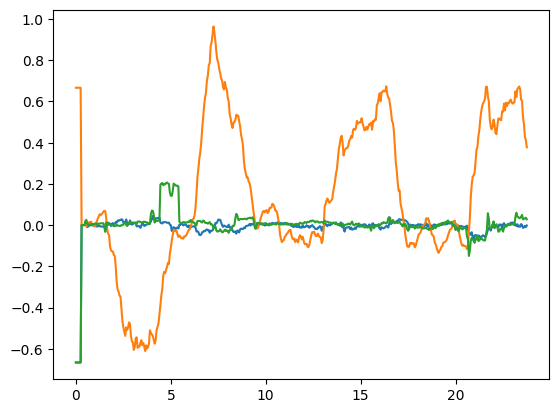

In [6]:
w= 20
fps= 20

X_w, Y_w, Z_w = (moving_average_cumsum([fps*x[0][1] for x in Rs[offset:]],w),
                 moving_average_cumsum([fps*x[0][2] for x in Rs[offset:]],w),
                 moving_average_cumsum([fps*x[1][2] for x in Rs[offset:]],w))


plt.plot([x/fps for x in range(len(X_w))], X_w)
plt.plot([x/fps for x in range(len(Y_w))], Y_w)
plt.plot([x/fps for x in range(len(Z_w))], Z_w)

In [7]:
def yawFromQuat(quat):
    '''extract yaw angle from quaternion'''
    q0, q1, q2, q3 = quat
    return np.arctan2(2*(q0*q3 + q1*q2), 1-2*(q2**2+q3**2))

def quatFromYaw(yaw):
    '''make quaternion from yaw angle'''
    q = np.array([np.cos(yaw/2), 0, 0, np.sin(yaw/2)])
    return q

def smoothTh(th, thPrev):
    while th - thPrev > np.pi: 
        th = th - 2*np.pi
    while th - thPrev < -np.pi:
        th = th + 2*np.pi
    return th

def hamProd(a, b):
    '''Hamilton product of two quaternions'''
    return np.array([a[0]*b[0]-a[1]*b[1]-a[2]*b[2]-a[3]*b[3],
                     a[0]*b[1]+a[1]*b[0]+a[2]*b[3]-a[3]*b[2],
                     a[0]*b[2]-a[1]*b[3]+a[2]*b[0]+a[3]*b[1],
                     a[0]*b[3]+a[1]*b[2]-a[2]*b[1]+a[3]*b[0]])
    
def reconstruct_with_quaternion(X_w, Y_w, Z_w, start_angle=0, fps=20):
    qPrev = quatFromYaw(start_angle)
    thPrev = start_angle
    ans_q = [qPrev]
    ans_ang = [thPrev]
    for i in range(len(X_w) - 1):
        qw = [0, X_w[i], Z_w[i], Y_w[i]]
        qdot = 1/2 * hamProd(qPrev, qw)
        dt = 1/fps
        q = qPrev + qdot*dt
        ans_q.append(q)
        th = smoothTh(yawFromQuat(q), thPrev)
        ans_ang.append(th)
        qPrev = q
        thPrev = th
    return ans_ang

In [8]:
Y_a = reconstruct_with_quaternion(X_w, Y_w, Z_w,start_angle=0)

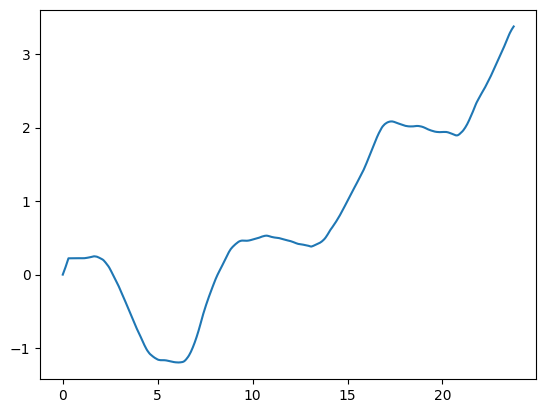

In [9]:
plt.plot([x/fps for x in range(len(Y_a))], Y_a)

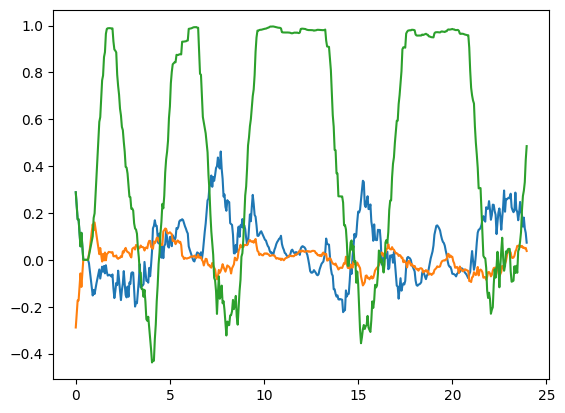

In [10]:
trans_x = [-x[0][0] for x in Ts]
trans_y = [-x[1][0] for x in Ts]
trans_z = [-x[2][0] for x in Ts]

ws= 20

trans_x = moving_average_cumsum(trans_x, ws)
trans_y = moving_average_cumsum(trans_y, ws)
trans_z = moving_average_cumsum(trans_z, ws)


plt.plot([x/fps for x in range(len(trans_x))], trans_x)
plt.plot([x/fps for x in range(len(trans_y))], trans_y)
plt.plot([x/fps for x in range(len(trans_z))], trans_z)

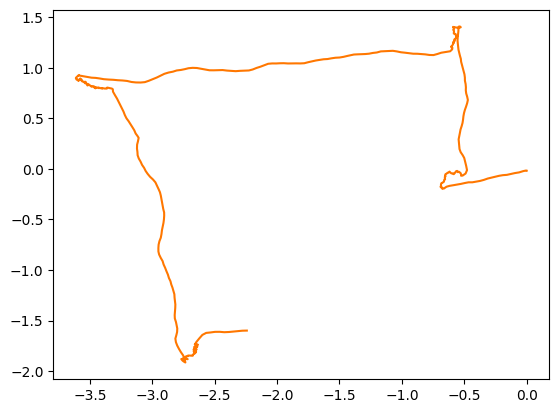

In [11]:
df = pd.read_csv('True_path.csv')

rx = [x[1]  for x in df.to_numpy()]
ry = [x[2]  for x in df.to_numpy()]

# for i in range(len(rx)):
#     rx[i] -= rx[-1]
#     ry[i] -= ry[-1]
plt.plot(rx, ry,c='#ff7700')

In [12]:
cordx = [0]
cordy = [0]

k =44
D = 0.24

for i in range(1,len(Y_a)):
    cordx.append((trans_z[i] * np.sin(Y_a[i] + D) + trans_z[i] * np.cos(Y_a[i] + D)) + cordx[-1])
    cordy.append((trans_z[i] * np.cos(Y_a[i] + D) + trans_z[i] * -np.sin(Y_a[i] + D)) + cordy[-1])



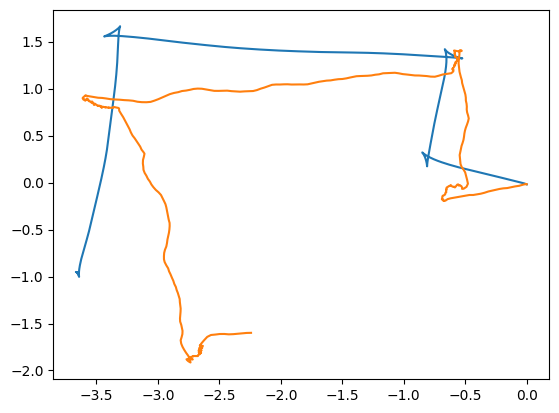

In [13]:
reference_cords = [[x for x in rx], [x for x in ry]]
decomposed_cords = [[-x/k + reference_cords[0][0]  for x in cordx], [x/k + reference_cords[1][0] for x in cordy]]
plt.plot(decomposed_cords[0], decomposed_cords[1])
plt.plot(reference_cords[0], reference_cords[1])

In [14]:
shortcut_idx= 0
L2_error = [0]
sci_step = len(reference_cords[0])/len(decomposed_cords[0])
for i in range(1,len(decomposed_cords[0])):
    nearest_sci_n = int(round(shortcut_idx, 0))
    L2_error.append(((reference_cords[0][nearest_sci_n] - decomposed_cords[0][i])**2 +
                     (reference_cords[1][nearest_sci_n] - decomposed_cords[1][i])**2)**0.5)
    shortcut_idx += sci_step

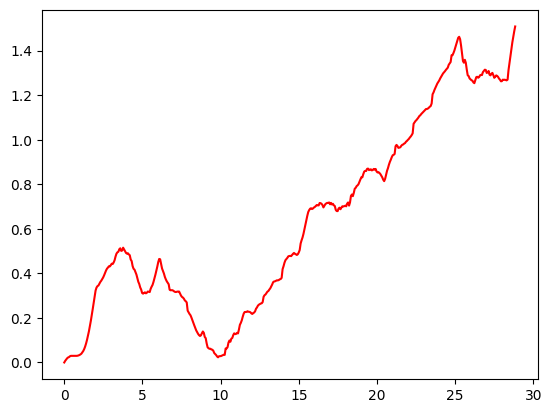

In [15]:
plt.plot([17/14*x/fps for x in range(len(L2_error))], L2_error,c='#ff0000')

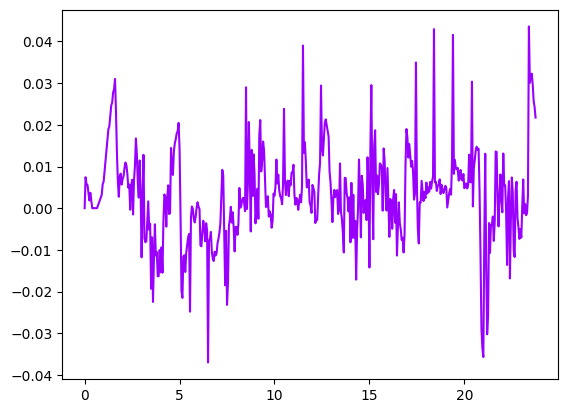

In [16]:
L2_error_der = [L2_error[i] - L2_error[i-1] for i in range(1,len(L2_error))]
L2_error_der.insert(0,0)
plt.plot([x/20 for x in range(len(L2_error))], L2_error_der,c='#9900ff')

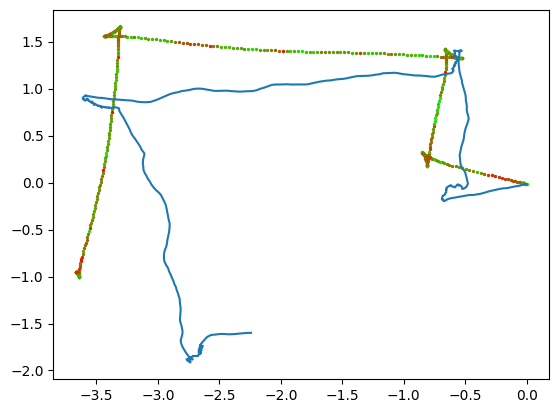

In [17]:
plt.plot(reference_cords[0], reference_cords[1])
for i in range(len(decomposed_cords[0])-1):
    plt.scatter(decomposed_cords[0][i], decomposed_cords[1][i], s=2,
                c=[[abs(L2_error_der[i]/max([abs(x) for x in L2_error_der]))**0.45,1-abs(L2_error_der[i]/max([abs(x) for x in L2_error_der]))**0.45,0]])